In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../python/')

In [2]:
import random
import via as VIA

from torch.utils.data import DataLoader
from dataset import VIADataset, ToTensor

via = VIA.load('../products/json/california.json')

keys = sorted(list(via.keys()))

random.seed(0)
random.shuffle(keys)

test_via = {key: via[key] for key in keys[400:]}
testset = ToTensor(VIADataset(test_via, '../resources/california/', shuffle=True))
testloader = DataLoader(testset, batch_size=10)

# Multi-Task SegNet

`MultiTaskSegNet` was trained with the `MultiTaskLoss` loss function for `63` epochs.

In [3]:
import torch
from torchsummary import summary
from models import MultiTaskSegNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskSegNet(3, 1, R=5).to(device)
model.load_state_dict(torch.load('../products/models/multisegnet_063.pth', map_location=device))

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

## Training

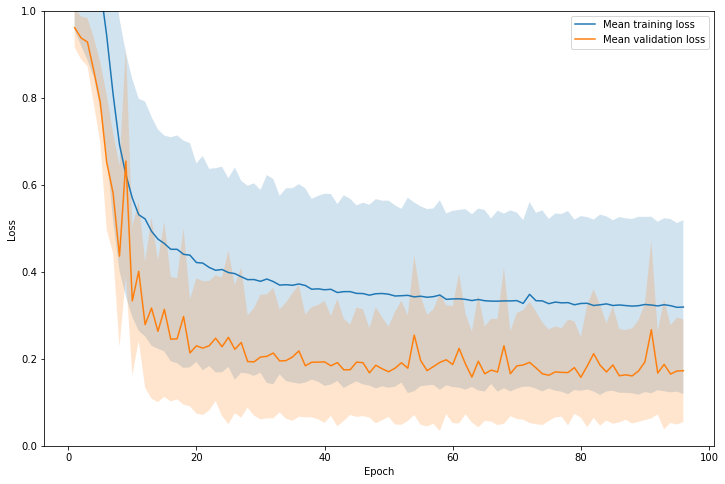

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

stats = pd.read_csv('../products/csv/multisegnet_statistics.csv')

plt.figure(figsize=(12, 8))

plt.plot(stats['epoch'], stats['train_loss_mean'], label='Mean training loss')
plt.fill_between(
    stats['epoch'],
    stats['train_loss_mean'] - stats['train_loss_std'],
    stats['train_loss_mean'] + stats['train_loss_std'],
    alpha=0.2
)

plt.plot(stats['epoch'], stats['valid_loss_mean'], label='Mean validation loss')
plt.fill_between(
    stats['epoch'],
    stats['valid_loss_mean'] - stats['valid_loss_std'],
    stats['valid_loss_mean'] + stats['valid_loss_std'],
    alpha=0.2
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0., 1.)
plt.legend()
plt.show()

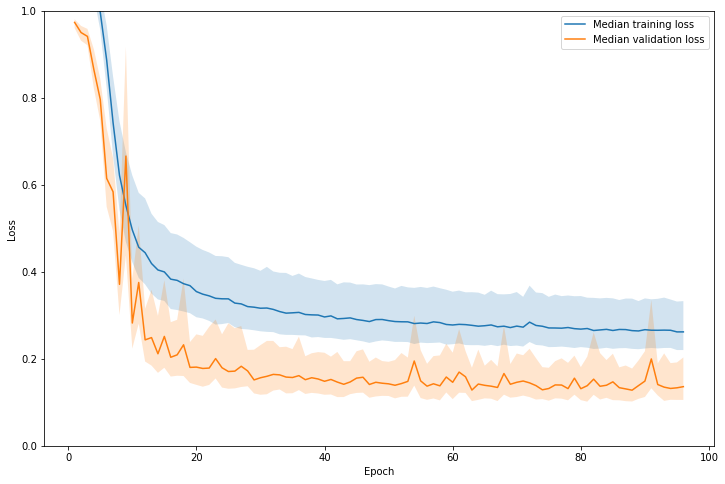

In [5]:
plt.figure(figsize=(12, 8))

plt.plot(stats['epoch'], stats['train_loss_second'], label='Median training loss')
plt.fill_between(
    stats['epoch'],
    stats['train_loss_first'],
    stats['train_loss_third'],
    alpha=0.2
)

plt.plot(stats['epoch'], stats['valid_loss_second'], label='Median validation loss')
plt.fill_between(
    stats['epoch'],
    stats['valid_loss_first'],
    stats['valid_loss_third'],
    alpha=0.2
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0., 1.)
plt.legend()
plt.show()

## Sample

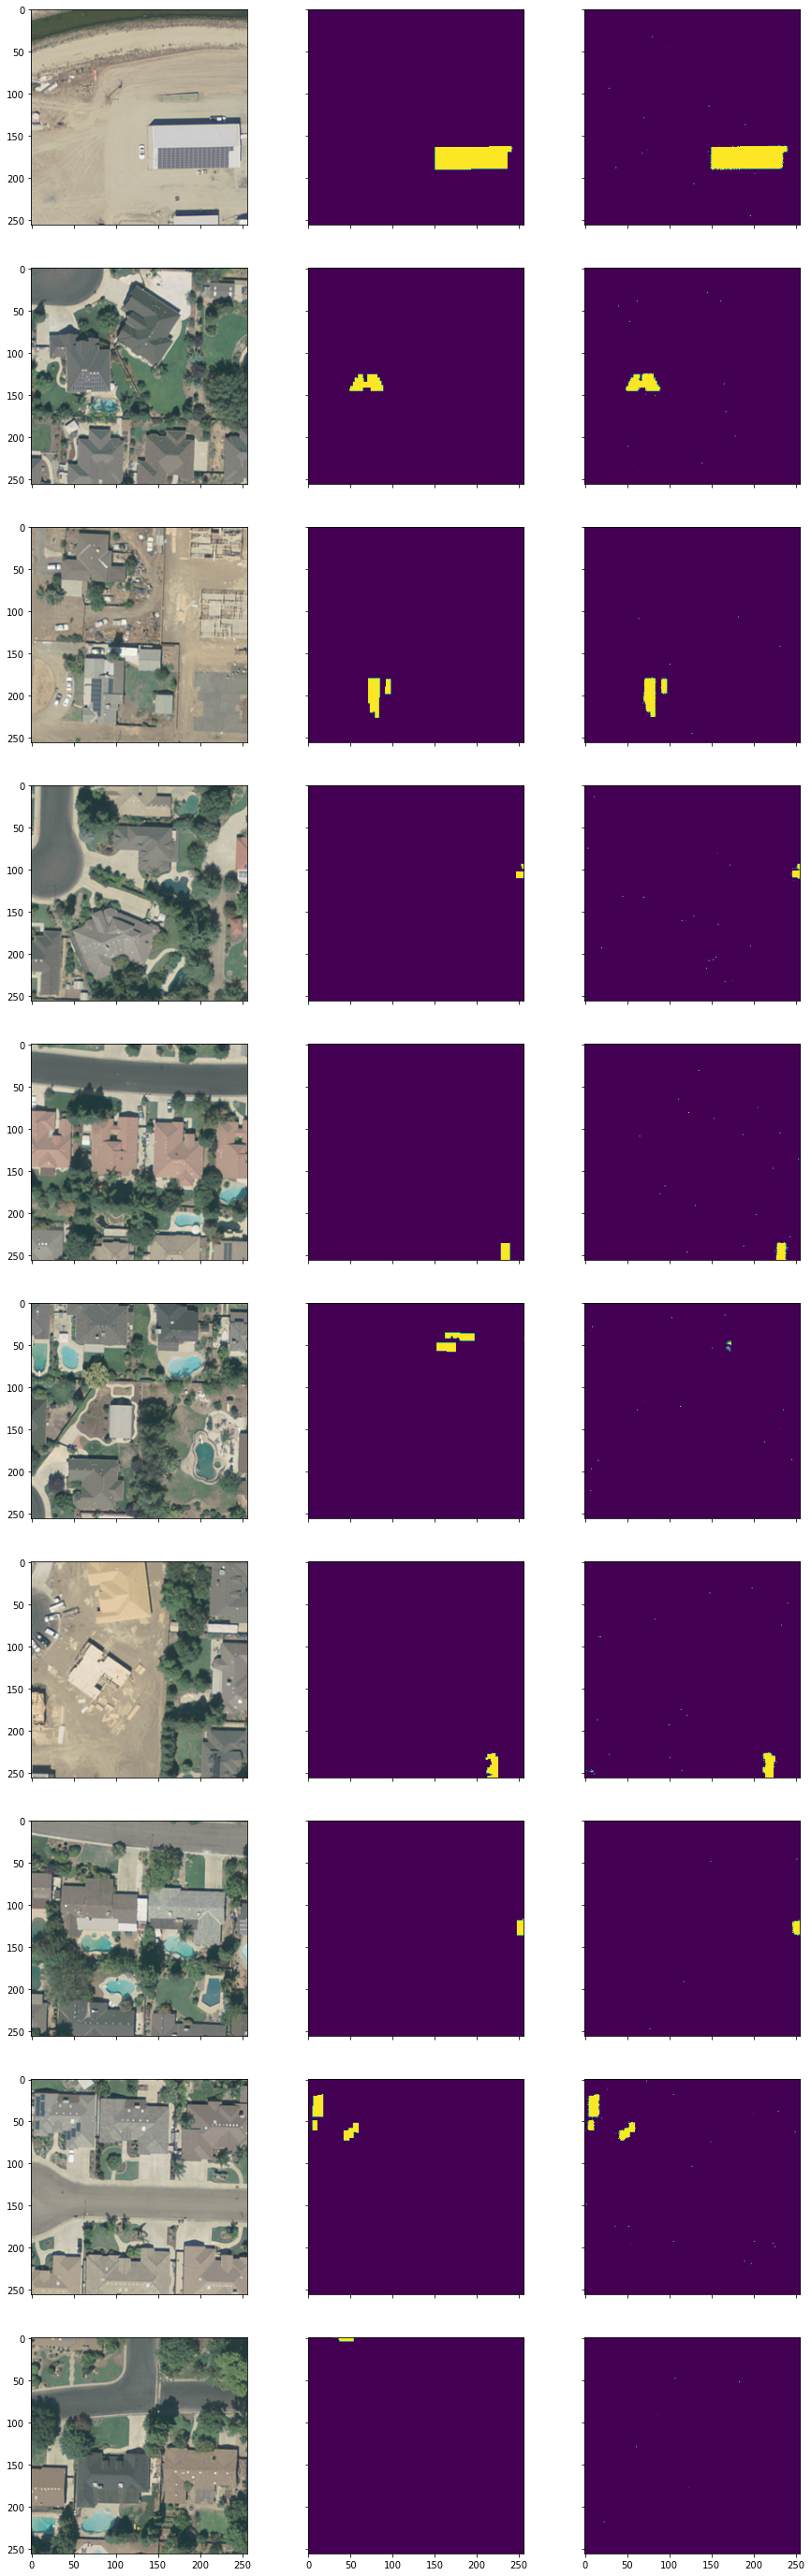

In [6]:
from dataset import to_pil
from plots import plot_alongside

model.eval()

with torch.no_grad():
    for inputs, targets in testloader:
        break

    outputs = model(inputs.to(device)).cpu()

plot_alongside(
    map(to_pil, inputs),
    map(to_pil, targets),
    map(to_pil, outputs),
    zoom=5
)

## Average precision

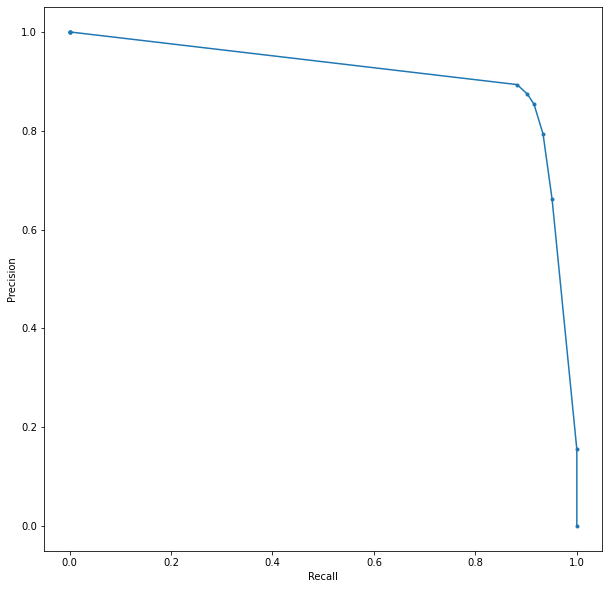

In [7]:
import numpy as np
import train

from criterions import TP, TN, FP, FN

metrics = train.eval(
    model,
    testloader,
    [m(x) for m in [TP, TN, FP, FN] for x in [0, 1e-6, 1e-3, 0.1, 0.5, 0.9, 1 - 1e-3, 1 - 1e-6, 1]]
)

tp, tn, fp, fn = np.sum(metrics, axis=0).reshape((4, -1))

precision = np.zeros(len(tp) + 2)
recall = np.zeros(precision.shape)
precision[-1] = recall[0] = 1

precision[1:-1] = (tp + 1e-9) / (tp + fp + 1e-9)
recall[1:-1] = (tp + 1e-9) / (tp + fn + 1e-9)

plt.figure(figsize=(10, 10))
plt.plot(recall, precision, '.-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [8]:
average_precision = -np.trapz(x=recall, y=precision)

print('Average precision = {}'.format(average_precision))

Average precision = 0.9119691125114927
